In [30]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, Dense, Flatten, Activation
import time
from sklearn.metrics import r2_score
import kerastuner as kt

In [2]:
#https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
physical_devices

[]

In [4]:
#df_Polyimides.to_csv('polyimides.cvs')  

In [43]:
Dataset1_Smiles_P = pd.read_csv('dataset1_imputed_all.csv')  
Dataset1_Smiles_P

,Unnamed: 0,index,Name,PID,Smiles,Details,Condition,Reference,Year,He,...,log10_O2_Bayesian,log10_N2_Bayesian,log10_CO2_Bayesian,log10_CH4_Bayesian,log10_He_Etree,log10_H2_Etree,log10_O2_Etree,log10_N2_Etree,log10_CO2_Etree,log10_CH4_Etree
0,0,0,polyethene,P010001,*C*,Dynamic method,"25 [C] ,","Pasternak, R. A.; Schimscheimer, J. F.; Heller...",1970,NaN,...,0.531479,-0.075721,1.110590,0.012254,1.201301,1.238196,0.531479,-0.075721,1.110590,-0.103039
1,1,1,polyethene,P010001,*C*,Dynamic method,"25 [C] ,","Pasternak, R. A.; Schimscheimer, J. F.; Heller...",1970,NaN,...,0.429002,-0.191294,1.037426,-0.101212,0.512792,0.845879,0.372675,-0.111720,1.037426,0.361122
2,2,2,polyethene,P010001,*C*,"Mocon Oxtran 100 equipment; P.S. Holden, G. A....","30 [C] ,","Holden, P. S.; Orchard, G. A. J.; Ward, I. M. ...",1985,NaN,...,-0.665546,-1.367414,-0.066764,-1.348410,0.803205,0.693273,-0.665546,-1.412270,-0.130830,-1.517954
3,3,3,polyethene,P010001,*C*,"Mocon Oxtran 100 equipment; P.S. Holden, G. A....","30 [C] ,","Holden, P. S.; Orchard, G. A. J.; Ward, I. M. ...",1985,NaN,...,-0.327902,-1.004516,0.274628,-0.963282,0.696047,0.613919,-0.327902,-1.146430,0.327439,-1.337536
4,4,4,polyethene,P010001,*C*,NaN,"25 [C] ,","Holden, P. S.; Orchard, G. A. J.; Ward, I. M. ...",1985,1.77,...,-0.013228,-0.490133,0.826281,-0.003425,0.247973,0.794222,-0.013228,-0.606161,0.774200,-0.306994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
773,773,313,Poly(2-adamanthyl vinyl ether),NaN,*CC(*)OC1C2CC3CC(C2)CC1C3,Vinyl and Vinylidene Polymers,NaN,http://dx.doi.org/10.1002/app.30834,2009,NaN,...,0.778874,0.227887,1.401401,0.360861,1.035338,1.350877,0.778874,0.227887,1.401401,0.498163
774,774,314,Poly(benzyl vinyl ether),NaN,*CC(*)OCc1ccccc1,Vinyl and Vinylidene Polymers,NaN,http://dx.doi.org/10.1002/app.30834,2009,NaN,...,0.367356,-0.102373,1.045323,0.067094,0.506273,0.849116,0.367356,-0.102373,1.045323,0.359446
775,775,315,Poly(cyclohexylmethyl vinyl ether),NaN,*CC(*)OCC1CCCCC1,Vinyl and Vinylidene Polymers,NaN,http://dx.doi.org/10.1002/app.30834,2009,NaN,...,0.190332,-0.397940,0.770115,-0.314109,0.966260,0.943327,0.190332,-0.397940,0.770115,-0.114003
776,776,316,Poly(8-tricyclo[5.2.1.0]decylmethyl vinyl ether),NaN,*CC(*)OCC1CC2CC1C1CCCC21,Vinyl and Vinylidene Polymers,NaN,http://dx.doi.org/10.1002/app.30834,2009,NaN,...,-0.091515,-0.886057,0.454845,-0.901289,0.922455,1.046136,-0.091515,-0.886057,0.454845,-1.037802


In [44]:
Dataset1_Smiles_P = Dataset1_Smiles_P.groupby('Smiles').mean().reset_index()
Dataset1_Smiles_P

,Smiles,Unnamed: 0,index,Year,He,H2,O2,N2,CO2,CH4,...,log10_O2_Bayesian,log10_N2_Bayesian,log10_CO2_Bayesian,log10_CH4_Bayesian,log10_He_Etree,log10_H2_Etree,log10_O2_Etree,log10_N2_Etree,log10_CO2_Etree,log10_CH4_Etree
0,*/C(=C(\*)c1ccc(-c2ccc(C(C)(C)C)cc2)cc1)c1ccccc1,750.5,269.5,2010.0,215.0,455.0,195.00,70.500,1220.00,190.000,...,2.264458,1.820241,3.064200,2.247077,2.322711,2.640971,2.264458,1.820241,3.064200,2.247077
1,*/C(=C(\*)c1ccc(-c2ccc([Si](C)(C)C)cc2)cc1)c1c...,743.0,262.0,2010.0,370.0,810.0,390.00,160.000,2200.00,450.000,...,2.591065,2.204120,3.342423,2.653213,2.568202,2.908485,2.591065,2.204120,3.342423,2.653213
2,*/C(=C(\*)c1ccc(-c2ccccc2)cc1)c1ccccc1,749.0,268.0,2010.0,200.0,440.0,180.00,65.000,1300.00,170.000,...,2.255273,1.812913,3.113943,2.230449,2.301030,2.643453,2.255273,1.812913,3.113943,2.230449
3,*/C(=C(\*)c1ccc(C(C)(C)C)cc1)c1ccc(O)cc1,707.0,226.0,2006.0,190.0,340.0,82.00,23.000,530.00,46.000,...,1.913814,1.361728,2.724276,1.662758,2.278754,2.531479,1.913814,1.361728,2.724276,1.662758
4,*/C(=C(\*)c1ccc(C(C)(C)C)cc1)c1ccc(O[Si](C)(C)...,703.0,222.0,2006.0,530.0,1000.0,470.00,210.000,2300.00,540.000,...,2.672098,2.322219,3.361728,2.732394,2.724276,3.000000,2.672098,2.322219,3.361728,2.732394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,*c1ccc2c(c1)C1(CC2(C)C)CC(C)(C)c2ccc(N3C(=O)c4...,653.0,144.0,2013.0,332.0,624.0,208.00,65.000,1523.00,129.000,...,2.318063,1.812913,3.182700,2.110590,2.521138,2.795185,2.318063,1.812913,3.182700,2.110590
349,*c1cccc(N2C(=O)c3ccc(Oc4ccc(C(C)(C)c5ccc(Oc6cc...,409.5,409.5,1994.0,9.4,NaN,0.37,0.051,1.33,0.036,...,-0.434351,-1.231009,0.121595,-1.291081,0.927353,0.736209,-0.434351,-1.295008,0.103035,-1.443242
350,*c1cccc(N2C(=O)c3ccc(Oc4ccc(C5(c6ccc(Oc7ccc8c(...,543.0,543.0,1989.0,NaN,NaN,0.30,NaN,NaN,NaN,...,-0.522879,-1.214076,0.077487,-1.185679,0.874861,0.748087,-0.522879,-1.311811,0.037426,-1.428914
351,*c1cccc(N2C(=O)c3ccc(Oc4ccc5c(c4)C4(CC(C)(C)c6...,542.0,542.0,1989.0,NaN,NaN,2.82,NaN,NaN,NaN,...,0.450249,-0.168164,1.061415,-0.075697,1.294916,1.406761,0.450249,-0.120979,1.151142,-0.084523


In [45]:
#dataset-1 fingerprint
molecules = Dataset1_Smiles_P.Smiles.apply(Chem.MolFromSmiles)

fp = molecules.apply(lambda m: AllChem.GetMorganFingerprint(m, radius=3))
fp_n = fp.apply(lambda m: m.GetNonzeroElements())

#fn = grouped['Smiles'].apply(Chem.MolFromSmiles).apply(lambda m: AllChem.GetMorganFingerprintAsBitVect(m, radius=3, nBits=2048))
#X_fingerprint = np.array(fn.tolist())
#X_fingerprint.shape


In [48]:
# using substructures in dataset-1 to construct a dictionary
HashCode = []
for i in fp_n:
    for j in i.keys():
        HashCode.append(j)
        
unique_set = set(HashCode)
unique_list = list(unique_set)

Corr_df = pd.DataFrame(unique_list).reset_index()

In [49]:
#construct dataset-1 input
MY_finger = []
for polymer in fp_n:
    my_finger = [0] * len(unique_list)
    for key in polymer.keys():
        index = Corr_df[Corr_df[0] == key]['index'].values[0]
        my_finger[index] = polymer[key]
    MY_finger.append(my_finger)
    
MY_finger_dataset_1 = pd.DataFrame(MY_finger)  

In [61]:
# filter input into the most popular 124 substructures
Zero_Sum = (MY_finger_dataset_1 == 0).astype(int).sum()
NumberOfZero = 6400
print(len(Zero_Sum[Zero_Sum < NumberOfZero]))
X_fingerprints = MY_finger_dataset_1[Zero_Sum[Zero_Sum < NumberOfZero].index]
X_fingerprints

3209


,0,1,2,3,4,5,6,7,8,9,...,3199,3200,3201,3202,3203,3204,3205,3206,3207,3208
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
349,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
350,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
351,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
#choose columns with missing values, imputed bayesian, or imputed Etree
Y = Dataset1_Smiles_P.iloc[:,-18:-12]
Y

,log10_He,log10_H2,log10_O2,log10_N2,log10_CO2,log10_CH4
0,2.322711,2.640971,2.264458,1.820241,3.064200,2.247077
1,2.568202,2.908485,2.591065,2.204120,3.342423,2.653213
2,2.301030,2.643453,2.255273,1.812913,3.113943,2.230449
3,2.278754,2.531479,1.913814,1.361728,2.724276,1.662758
4,2.724276,3.000000,2.672098,2.322219,3.361728,2.732394
...,...,...,...,...,...,...
348,2.521138,2.795185,2.318063,1.812913,3.182700,2.110590
349,0.973128,NaN,-0.434351,-1.292430,0.123852,-1.443697
350,NaN,NaN,-0.522879,NaN,NaN,NaN
351,NaN,NaN,0.450249,NaN,NaN,NaN


In [55]:
Y.max()
Y = Y / Y.max()
Y = Y.values

In [56]:
X = X_fingerprints
#X = X.astype('float64')
#import keras.backend as K

In [57]:
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import ops
tf.keras.backend.set_floatx('float64')

In [58]:
def nanmean_squared_error(y_true, Y_pred):
    Y_pred = ops.convert_to_tensor_v2(Y_pred)
    y_true = math_ops.cast(y_true, Y_pred.dtype)
    residuals = (y_true - Y_pred)
    residuals_no_nan = tf.where(tf.math.is_nan(residuals), tf.zeros_like(residuals), residuals)
    sum_residuals = tf.reduce_sum(math_ops.squared_difference(residuals_no_nan , 0),-1) / tf.reduce_sum(tf.cast(~tf.math.is_nan(y_true), tf.float64),-1)
    return sum_residuals

In [80]:
X_train, X_test, Y_train, Y_test=train_test_split(X, Y, test_size=0.2, random_state=12)
print("X_train:", X_train.shape, "Y_train:", Y_train.shape)

model = Sequential()
model.add(Dense(8, input_dim=X.shape[1], activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(6))

model.compile(loss=nanmean_squared_error, optimizer="Adam")
model.summary()
 
history = model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data = ((X_test), Y_test), verbose=2)

X_train: (282, 3209) Y_train: (282, 6)
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 8)                 25680     
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 72        
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_23 (Dense)             (None, 6)                 54        
Total params: 25,806
Trainable params: 25,806
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
9/9 - 0s - loss: 0.2040 - val_loss: 0.1471
Epoch 2/100
9/9 - 0s - loss: 0.1734 - val_loss: 0.1289
Epoch 3/100
9/9 - 0s - loss: 0.1581 - val_loss: 0.1129
Epoch 4/100
9/9 - 0s - loss: 0.1400 - val_lo

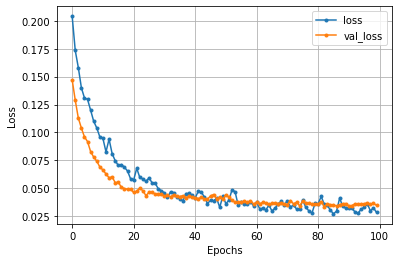

In [81]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = len(loss)
plt.plot(range(epochs), loss, marker = '.', label = 'loss')
plt.plot(range(epochs), val_loss, marker = '.', label = 'val_loss')
plt.legend(loc = 'best')

plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.savefig("./DNN_fingerprint_Loss.png", dpi=600, bbox_inches='tight')
plt.show()

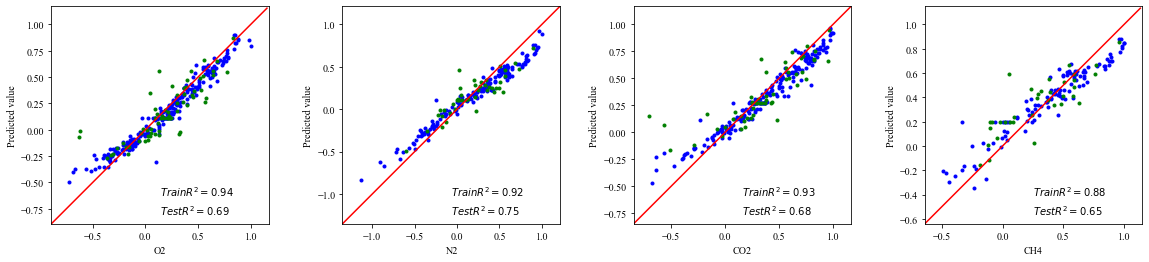

In [84]:
Columns = ['O2','N2','CO2','CH4']
Y_pred_train = model.predict((X_train))
Y_pred_test = model.predict((X_test))
plt.figure(figsize=(20,4))
for i in range(4):
    ax=plt.subplot(1, 4, i + 1)
    index = i + 2
    flag1 = ~np.isnan(Y_train[:,index])
    plt.plot(Y_train[:,index][flag1], Y_pred_train[:,index][flag1], 'b.')#, alpha=0.8, label="Train R^2: {}".format(r2_score(y_train, Y_pred_train)))
    flag2 = ~np.isnan(Y_test[:,index])
    plt.plot(Y_test[:,index][flag2], Y_pred_test[:,index][flag2], 'g.')#, alpha=0.8, label="Test R^2: {}".format(r2_score(y_test, Y_pred_test)))
    #plt.legend(loc = 'best')
    plt.xlabel(Columns[i],fontname="Times New Roman") #, fontsize=15
    plt.ylabel("Predicted value",fontname="Times New Roman") #, fontsize=15)
    x0, x1 = min(Y_train[:,index][flag1]), max(Y_train[:,index][flag1])
    length = x1 - x0
    x_start, x_end = x0-0.1*length, x1+0.1*length
    plt.xlim([x_start, x_end])
    plt.ylim([x_start, x_end])
    # ax.set_xticks([-200,-100,0,100,200,300,400,500])
    # ax.set_yticks([-200,-100,0,100,200,300,400,500])
    plt.xticks(fontname="Times New Roman") #, fontsize=15)
    plt.yticks(fontname="Times New Roman") #, fontsize=15)
    plt.gca().set_aspect("equal", adjustable="box")
    # the unit line
    plt.plot(np.arange(x_start, x_end, 0.01*length),
    np.arange(x_start, x_end, 0.01*length), 'r-')
    plt.text(x_end - 0.6*length, x_start + 0.15*length, "$Train R^2={:.2f}$".format(r2_score(Y_train[:,index][flag1], Y_pred_train[:,index][flag1])))
    plt.text(x_end - 0.6*length, x_start + 0.05*length, "$Test R^2={:.2f}$".format(r2_score(Y_test[:,index][flag2], Y_pred_test[:,index][flag2])))
    #plt.savefig("./DNN_fingerprint.png", dpi=600, bbox_inches='tight')
    #plt.savefig("DNN_fingerprint.svg", bbox_inches='tight')